First 10 values in 'HitLocalTime':
0                   NaT
1   2020-06-17 02:11:35
2   2020-06-17 02:11:53
3   2020-06-17 02:12:46
4   2020-06-17 02:43:40
5   2020-06-17 02:44:00
6   2020-06-17 02:44:11
7   2020-06-17 02:51:25
8   2020-06-17 02:51:36
9   2020-06-17 02:51:45
Name: HitLocalTime, dtype: datetime64[ns]
First 10 dates in 'Date' column:
0           NaT
1    2020-06-17
2    2020-06-17
3    2020-06-17
4    2020-06-17
5    2020-06-17
6    2020-06-17
7    2020-06-17
8    2020-06-17
9    2020-06-17
Name: Date, dtype: object
Checking for missing values in daily features:
Date            0
NumShots        0
SuccessRate     0
NumSuccesses    0
NumMisses       0
dtype: int64
First 10 rows of 'daily_features':
         Date  NumShots  SuccessRate  NumSuccesses  NumMisses
0  2020-06-17        88     0.568182          50.0       38.0
1  2020-06-18       350     0.708571         248.0      102.0
2  2020-06-19       407     0.719902         293.0      114.0
3  2020-06-20       443     0.7

C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clustering results on daily shot patterns:
          Date  NumShots  SuccessRate  NumSuccesses  NumMisses  Cluster
0   2020-06-17        88     0.568182          50.0       38.0        1
1   2020-06-18       350     0.708571         248.0      102.0        2
2   2020-06-19       407     0.719902         293.0      114.0        2
3   2020-06-20       443     0.742664         329.0      114.0        0
4   2020-06-21       585     0.738462         432.0      153.0        0
5   2020-06-22       548     0.686131         376.0      172.0        0
6   2020-06-23       450     0.668889         301.0      149.0        0
7   2020-06-24       300     0.690000         207.0       93.0        2
8   2020-06-25       306     0.732026         224.0       82.0        2
9   2020-06-26       100     0.760000          76.0       24.0        1
10  2020-06-27       495     0.737374         365.0      130.0        0
11  2020-06-28       227     0.779736         177.0       50.0        1
12  2020-06-29       

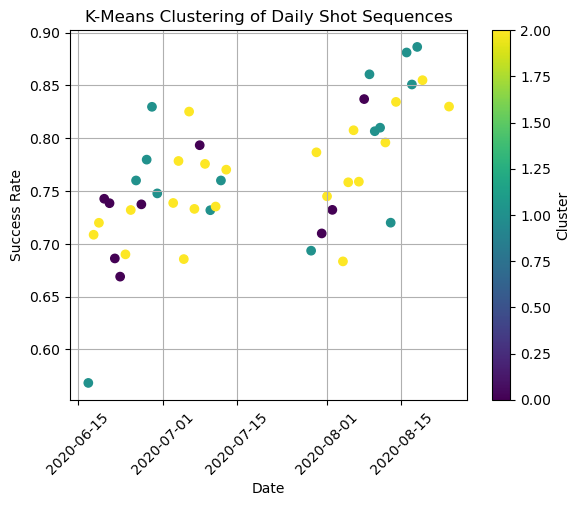

In [6]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: טעינת הנתונים
file_path = r"C:\Users\guymk\Downloads\data13 (1).csv"  # נתיב לקובץ שלך
data_cleaned = pd.read_csv(file_path)

# Step 2: יצירת פונקציה לניקוי והמרת התאריכים בפורמט ידני מתוך המחרוזות
def extract_datetime(text):
    try:
        # חיפוש תאריך ושעה בעזרת Regex
        match = re.search(r'\w+ \w+ \d+ \d+ \d+:\d+:\d+', text)
        if match:
            return pd.to_datetime(match.group(0))
        else:
            return pd.NaT  # אם לא נמצא תאריך, מחזירים NaT
    except Exception as e:
        return pd.NaT

# Step 3: המרת העמודה Unnamed: 1 בעזרת הפונקציה הידנית
data_cleaned['HitLocalTime'] = data_cleaned['Unnamed: 1'].apply(extract_datetime)

# בדיקה אם עמודת HitLocalTime באמת התעדכנה
print("First 10 values in 'HitLocalTime':")
print(data_cleaned['HitLocalTime'].head(10))

# Step 4: הוספת עמודת תאריך כדי שנוכל לקבץ את הזריקות לפי יום
data_cleaned['Date'] = data_cleaned['HitLocalTime'].dt.date

# בדיקת תאריכים
print("First 10 dates in 'Date' column:")
print(data_cleaned['Date'].head(10))

# Step 5: המרת העמודה 'Made' למספרית: TRUE = 1, FALSE = 0
data_cleaned['MadeNumeric'] = data_cleaned['Unnamed: 7'].map({'TRUE': 1, 'FALSE': 0})

# Step 6: יצירת מאפייני רצף יומיים: מספר זריקות ביום, אחוזי הצלחה, מספר הצלחות והחטאות ביום
daily_features = data_cleaned.groupby('Date').agg(
    NumShots=('MadeNumeric', 'count'),
    SuccessRate=('MadeNumeric', 'mean'),
    NumSuccesses=('MadeNumeric', 'sum'),
    NumMisses=('MadeNumeric', lambda x: (1 - x).sum())
).reset_index()

# בדיקה אם יש ערכים ריקים בעמודות של daily_features
print("Checking for missing values in daily features:")
print(daily_features.isnull().sum())

# הצגת חלק מהנתונים כדי לוודא תקינות
print("First 10 rows of 'daily_features':")
print(daily_features.head(10))

# Step 7: מילוי ערכים חסרים (אם יש) ב-0
daily_features = daily_features.fillna(0)

# Step 8: ביצוע קלאסטרינג עם K-Means על הימים
if not daily_features.empty:
    kmeans = KMeans(n_clusters=3, random_state=42)
    daily_features['Cluster'] = kmeans.fit_predict(daily_features[['SuccessRate', 'NumSuccesses', 'NumMisses']])
else:
    print("No data available for clustering.")

# Step 9: הצגת התוצאות
if 'Cluster' in daily_features.columns:
    print("Clustering results on daily shot patterns:")
    print(daily_features)

    # Step 10: ויזואליזציה של התוצאות
    plt.scatter(daily_features['Date'], daily_features['SuccessRate'], 
                c=daily_features['Cluster'], cmap='viridis', marker='o')
    plt.title('K-Means Clustering of Daily Shot Sequences')
    plt.xlabel('Date')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=45)
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.show()
else:
    print("Clustering could not be performed due to lack of data.")


In [7]:
# Step 1: הוספת עמודת שעה
data_cleaned['Hour'] = data_cleaned['HitLocalTime'].dt.hour

# Step 2: יצירת רצפים לפי חלוקה של בוקר, צהריים וערב
data_cleaned['TimeOfDay'] = pd.cut(data_cleaned['Hour'], bins=[0, 11, 17, 23], labels=['Morning', 'Afternoon', 'Evening'])

# Step 3: חישוב המאפיינים עבור כל יום בכל חלק ביום (בוקר, צהריים, ערב)
daily_features_time = data_cleaned.groupby(['Date', 'TimeOfDay']).agg(
    NumShots=('MadeNumeric', 'count'),
    SuccessRate=('MadeNumeric', 'mean'),
    NumSuccesses=('MadeNumeric', 'sum'),
    NumMisses=('MadeNumeric', lambda x: (1 - x).sum())
).reset_index()

# Step 4: חלוקה לפי חלקים שונים ביום
print(daily_features_time.head())

# Step 5: ביצוע קלאסטרינג על פי תתי-הקבוצות של בוקר, צהריים וערב
kmeans = KMeans(n_clusters=3, random_state=42)
daily_features_time['Cluster'] = kmeans.fit_predict(daily_features_time[['SuccessRate', 'NumSuccesses', 'NumMisses']])

# Step 6: ויזואליזציה של התוצאות לפי חלקי היום
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Date', y='SuccessRate', hue='Cluster', style='TimeOfDay', data=daily_features_time, palette='viridis', s=100)
plt.title('K-Means Clustering of Daily Shot Sequences (Morning, Afternoon, Evening)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


C:\Users\guymk\AppData\Local\Temp\ipykernel_33360\484299731.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_features_time = data_cleaned.groupby(['Date', 'TimeOfDay']).agg(


         Date  TimeOfDay  NumShots  SuccessRate  NumSuccesses  NumMisses
0  2020-06-17    Morning        17     0.588235          10.0        7.0
1  2020-06-17  Afternoon         0          NaN           0.0        NaN
2  2020-06-17    Evening        71     0.563380          40.0       31.0
3  2020-06-18    Morning       250     0.704000         176.0       74.0
4  2020-06-18  Afternoon         0          NaN           0.0        NaN


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


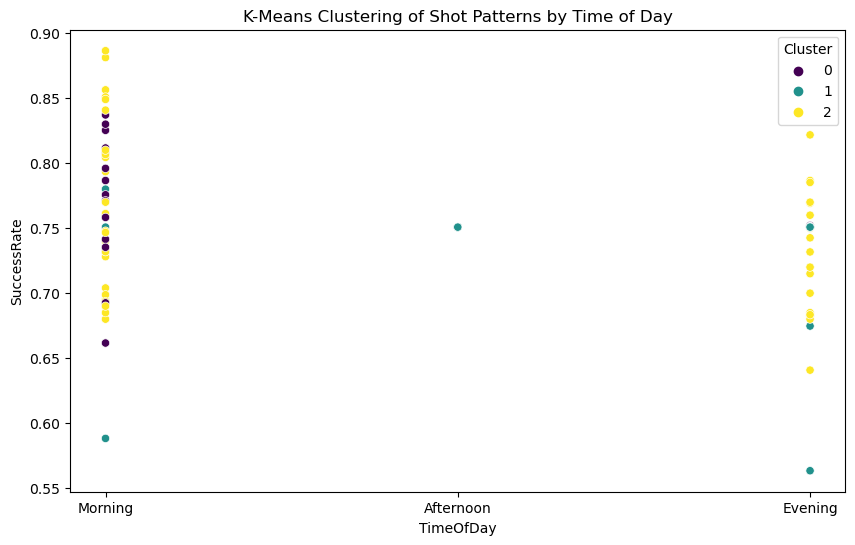

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: ביצוע מילוי לערכים חסרים
imputer = SimpleImputer(strategy='mean')
daily_features_time[['SuccessRate', 'NumSuccesses', 'NumMisses']] = imputer.fit_transform(
    daily_features_time[['SuccessRate', 'NumSuccesses', 'NumMisses']])

# Step 2: ביצוע קלאסטרינג עם K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
daily_features_time['Cluster'] = kmeans.fit_predict(daily_features_time[['SuccessRate', 'NumSuccesses', 'NumMisses']])

# Step 3: ויזואליזציה של התוצאות
plt.figure(figsize=(10, 6))
sns.scatterplot(data=daily_features_time, x='TimeOfDay', y='SuccessRate', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering of Shot Patterns by Time of Day')
plt.show()


C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

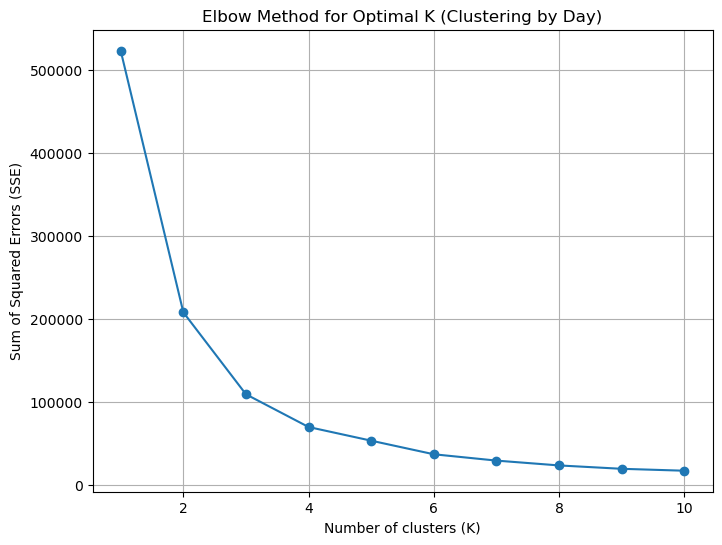

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: הגדרת הטווח של מספר הקלאסטרים שאנו רוצים לבדוק (למשל בין 1 ל-10)
sse = []  # Sum of squared errors (SSE)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(daily_features[['SuccessRate', 'NumSuccesses', 'NumMisses']])
    sse.append(kmeans.inertia_)  # הוספת ה-SSE לכל מספר קלאסטרים

# Step 2: ציור הגרף של elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal K (Clustering by Day)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()


C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clustering results on daily shot patterns:
         Date  NumShots  SuccessRate  NumSuccesses  NumMisses  Cluster
0  2020-06-17        88     0.568182          50.0       38.0        2
1  2020-06-18       350     0.708571         248.0      102.0        0
2  2020-06-19       407     0.719902         293.0      114.0        0
3  2020-06-20       443     0.742664         329.0      114.0        1
4  2020-06-21       585     0.738462         432.0      153.0        1


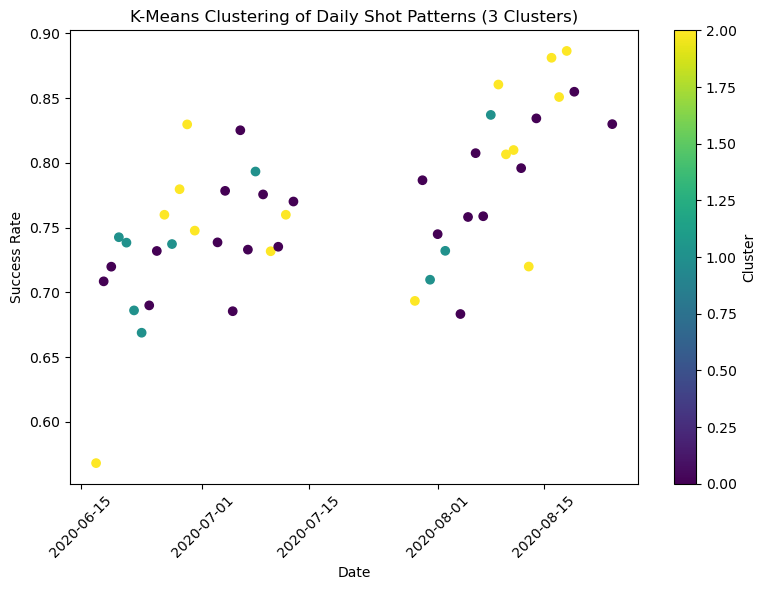

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: ביצוע K-Means עם 3 קלאסטרים על בסיס מה שמצאנו
kmeans = KMeans(n_clusters=3, random_state=42)
daily_features['Cluster'] = kmeans.fit_predict(daily_features[['NumShots', 'SuccessRate', 'NumSuccesses', 'NumMisses']])

# Step 2: הצגת התוצאות של הקלאסטרינג
print("Clustering results on daily shot patterns:")
print(daily_features.head())

# Step 3: ויזואליזציה של הקלאסטרינג לפי הצלחות היומיות והקלאסטרים
plt.figure(figsize=(8,6))
plt.scatter(daily_features['Date'], daily_features['SuccessRate'], c=daily_features['Cluster'], cmap='viridis')
plt.title("K-Means Clustering of Daily Shot Patterns (3 Clusters)")
plt.xlabel("Date")
plt.ylabel("Success Rate")
plt.colorbar(label='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# Cleaning the data to remove rows with NaN values
daily_features_cleaned = daily_features[['SuccessRate', 'NumSuccesses', 'NumMisses']].dropna()

# Running K-Means with 3 clusters (based on Elbow method)
kmeans_3 = KMeans(n_clusters=3, random_state=42)
daily_features_cleaned['Cluster'] = kmeans_3.fit_predict(daily_features_cleaned)

# Calculating Silhouette Score for the clustering
silhouette_avg = silhouette_score(daily_features_cleaned[['SuccessRate', 'NumSuccesses', 'NumMisses']], daily_features_cleaned['Cluster'])

print(f'Silhouette Score for 3 clusters: {silhouette_avg}')


C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for 3 clusters: 0.49681532048050026


C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

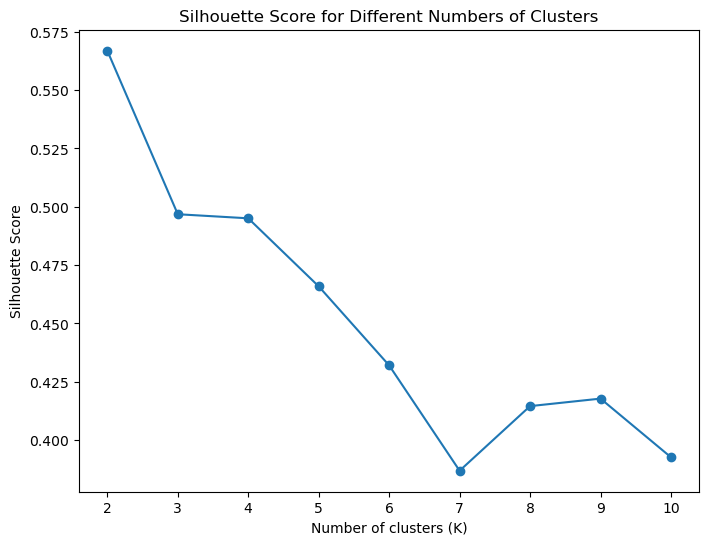

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# ניקוי הדאטה כדי להסיר שורות עם ערכי NaN
daily_features_cleaned = daily_features[['SuccessRate', 'NumSuccesses', 'NumMisses']].dropna()

# טווח מספר הקלאסטרים לבדיקה
range_n_clusters = list(range(2, 11))

# רשימה לאחסון תוצאות ה-Silhouette לכל מספר קלאסטרים
silhouette_scores = []

# חישוב ציון ה-Silhouette לכל מספר קלאסטרים בטווח
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(daily_features_cleaned)
    silhouette_avg = silhouette_score(daily_features_cleaned, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# הצגת הגרף של ציון ה-Silhouette עבור מספרי הקלאסטרים השונים
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()


C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\guymk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for 2 clusters: 0.566898386804396


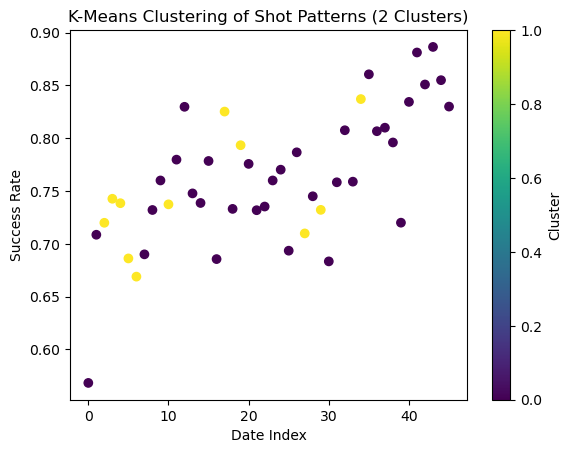

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

# ניקוי הדאטה להסרת ערכים חסרים (NaN)
daily_features_cleaned = daily_features[['SuccessRate', 'NumSuccesses', 'NumMisses']].dropna()

# ביצוע קלאסטרינג עם 2 קלאסטרים (בהתאם לתוצאות Silhouette)
kmeans_2 = KMeans(n_clusters=2, random_state=42)
daily_features_cleaned['Cluster'] = kmeans_2.fit_predict(daily_features_cleaned)

# חישוב ציון Silhouette עבור הקלאסטרינג עם 2 קלאסטרים
silhouette_avg = silhouette_score(daily_features_cleaned[['SuccessRate', 'NumSuccesses', 'NumMisses']], daily_features_cleaned['Cluster'])
print(f'Silhouette Score for 2 clusters: {silhouette_avg}')

# הצגת התוצאות בגרף
plt.scatter(daily_features_cleaned.index, daily_features_cleaned['SuccessRate'], c=daily_features_cleaned['Cluster'], cmap='viridis')
plt.title('K-Means Clustering of Shot Patterns (2 Clusters)')
plt.xlabel('Date Index')
plt.ylabel('Success Rate')
plt.colorbar(label='Cluster')
plt.show()


## Summary and Conclusions of Our Analysis:

Objective: The goal was to perform clustering on shot data based on daily patterns to identify good versus bad performance days using metrics such as shot success rates.

Data Preprocessing: We processed the data to calculate daily shot success rates, the number of successful shots, and the number of misses for each day.

Clustering Using K-Means:

We applied K-Means clustering on daily data, experimenting with different numbers of clusters (e.g., 2 clusters, 3 clusters, etc.).
We used the Elbow Method to identify the optimal number of clusters based on the sum of squared errors (SSE) as it decreases with each additional cluster.
We also employed the Silhouette Score to measure the quality of clustering for different cluster numbers.
Key Results:

Based on the Elbow Method, the optimal number of clusters was 3, as the reduction in error became less significant after adding the third cluster.
The Silhouette Score suggested that 2 clusters provided better separation of the data (with a score of 0.566), indicating that two clusters offered clearer division compared to three clusters.
Analysis of the Results:
Clustering by Days:

We successfully clustered the days based on shot success rates and failures.
With 2 clusters, we could separate high-performing days (with higher success rates) from lower-performing ones.
With 3 clusters, the separation was more granular, but the Silhouette Score indicated that the division with 2 clusters was sharper.

## Conclusions:
Preference for 2 Clusters: Based on the Silhouette Score, 2 clusters seemed to give the best separation of the days in terms of shot performance.
